##### 감성 분류(Sentiment Analysis)

- 고객의 리뷰를 바탕으로 긍정 / 부정  분류
- 데이터 셋 : 네이버 영화 리뷰 
- 데이터 수 : 200,000개

## [1] 데이터 준비 및 확인

In [4]:
#모듈 로딩 --------------------------------------------------------------------
import pandas as pd,  numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
TEST_FILE='./data/ratings_test.txt'
TRAIN_FILE='./data/ratings_train.txt'

### [1-1] 데이터 준비

In [6]:
trainDF = pd.read_table(TRAIN_FILE)
testDF = pd.read_table(TEST_FILE)

In [7]:
print(f'학습용 리뷰 수 : {len(trainDF)}, 테스트용 리뷰 수 : {len(testDF)}')

학습용 리뷰 수 : 150000, 테스트용 리뷰 수 : 50000


### [1-2] 데이터 확인

- 학습용 데이터 확인 ==================================================================

In [8]:
def checkDataInfo(df, df_name):
    print(f'[{df_name} 기본 정보]====================')
    df.info()
    print(f'\ncolumns : {df.columns}\n')

In [9]:
checkDataInfo(trainDF, 'trainDF')

[trainDF 기본 정보]====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB

columns : Index(['id', 'document', 'label'], dtype='object')



In [10]:
trainDF.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- 테스트용 데이터 확인

In [11]:
checkDataInfo(testDF, 'testDF')

[testDF 기본 정보]====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB

columns : Index(['id', 'document', 'label'], dtype='object')



In [12]:
testDF.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## [2] 데이터 전처리

- 기본 데이터 전처리
    * 컬럼 정리
    * 결측치
    * 중복데이터
- 텍스트 데이터 전처리
    * 특정 언어(한글: ㄱ ~ ㅎ, ㅏ ~ ㅣ, 영어 : a ~ z)
    * 구두점
    * 불용어=> 커스터마이징 
    * 맞춤법, 띄어쓰기

#### [2-1] 기본 데이터 전처리 

- 컬럼 정리 =================================================
: id 컬럼 제거

In [13]:
train_data = trainDF.drop('id', axis=1)
test_data = testDF.drop('id', axis=1)

In [14]:
train_data.columns, test_data.columns

(Index(['document', 'label'], dtype='object'),
 Index(['document', 'label'], dtype='object'))

- 결측치 체크 ===============================================

In [15]:
def checkNullData(data, col, do=False):
    print(f"결측 데이터 수 :{data.isnull().sum()}")
    
    if do == True:
        print(f"삭제 전 :{data.shape}")
        data.dropna(inplace=True)
        print(f"삭제 후 :{data.shape}\n")
    elif do == False:
        pass
    else:
        print(f"치환 전 :{data.shape}")
        data[col].fillna(do, inplace=True)
        print(f"치환 후 :{data.shape}\n")        

In [16]:
checkNullData(train_data, 'document', True)

결측 데이터 수 :document    5
label       0
dtype: int64
삭제 전 :(150000, 2)
삭제 후 :(149995, 2)



In [17]:
checkNullData(test_data, 'document', True)

결측 데이터 수 :document    3
label       0
dtype: int64
삭제 전 :(50000, 2)
삭제 후 :(49997, 2)



- 중복 데이터 즉, 행 삭제 ===================================

In [18]:
def checkDuplicate(data, col, remove=True):
    print(f"중복 데이터 수 :{data.duplicated(subset=[col]).sum()}")
    
    if remove:
        print(f"처리 전 :{data.shape}")
        data.drop_duplicates(subset=[col], inplace=True)
        print(f"삭제 후 :{data.shape}\n")

In [19]:
# 중복 데이터 존재 여부 체크
checkDuplicate(train_data, 'document')
checkDuplicate(test_data, 'document')

중복 데이터 수 :3813
처리 전 :(149995, 2)
삭제 후 :(146182, 2)

중복 데이터 수 :840
처리 전 :(49997, 2)
삭제 후 :(49157, 2)



- 라벨/클래스별 데이터 분포 확인 =========================

In [20]:
import matplotlib.pyplot as plt

In [21]:
def displayDataDistribution(data, title):
    labelsSR=data.value_counts()
    nums = labelsSR.index
    
    plt.figure(figsize=(4,5))
    plt.title(title)
    plt.bar(labelsSR.index, labelsSR)
    plt.xticks([0, 1], ["N", "P"])
    for x, y in zip(nums, labelsSR):
        label=f'{y} volume'
        plt.text(x, y, label,color='red',  
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='center')    # verticalalignment (top, center, bottom)
        

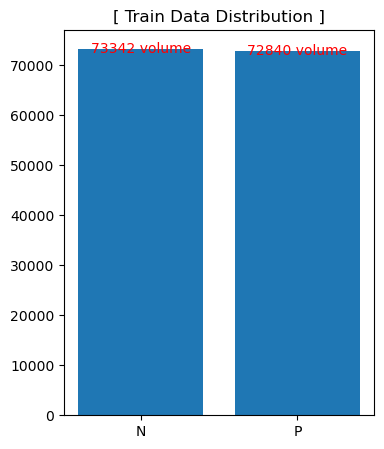

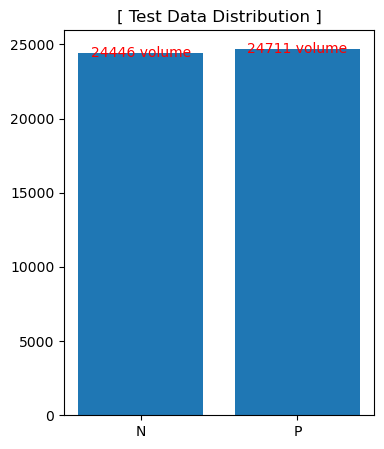

In [22]:
displayDataDistribution(train_data.label, '[ Train Data Distribution ]')

displayDataDistribution(test_data.label, '[ Test Data Distribution ]')

#### [2-2] 텍스트 데이터 전처리

- 텍스트 데이터 정제(CLEANING) : 한글, 공백 제외한 나머지 문자 제거
    * 정규표현식 : "[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"

In [23]:
def checkAlphaSpace(data, regText):
    data.document.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [24]:
train_data.shape

(146182, 2)

In [25]:
train_data.document.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 146182, dtype: object

In [26]:
train_data.isnull().sum()

document    0
label       0
dtype: int64

#### 토큰화 

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
import string

In [28]:
NUM_WORDS=5000
FILTER=string.punctuation

In [29]:
tokenizer = Tokenizer(num_words=NUM_WORDS, filters=FILTER)

In [30]:
tokenizer.fit_on_texts(train_data.document)

In [31]:
# 토큰 단어 수 확인
len(tokenizer.word_counts)

295179

In [32]:
wordCounts=tokenizer.word_counts

In [33]:
type(wordCounts)

collections.OrderedDict

- 불용어 제거 -------------------------------------------------------------

In [38]:
SW='./data/stopwords_kor.txt'

In [39]:
with open(SW, mode='r', encoding='UTF-8') as f:
    stopWords=f.read()

In [40]:
stopWords=stopWords.replace('\n',',')

In [41]:
len(stopWords)

2891